Import all the necessary modules

In [1]:
# import all the modules you need
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

Load images to an array called `img`

In [2]:
img = [] # create an empty list

# find all files and load them into img using a for loop
for fname in glob.glob("G4_20220811\\images\\*.bmp"):
    img.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))

# convert the list into an array
img = np.array(img, dtype='float32')
print("Image array has shape: "+str(img.shape)+"\nIt is a stack of "+str(img.shape[0])+" images, each comprising "+str(img.shape[1])+" rows and "+str(img.shape[2])+" columns")


Image array has shape: (10, 1200, 1600)
It is a stack of 10 images, each comprising 1200 rows and 1600 columns


Display an image for fun

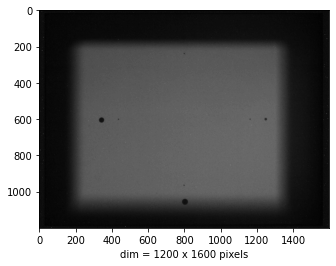

A-side on left, B-side on right. G-side on top, T-side on bottom


In [3]:
plt.imshow(img[0,:,:], cmap='gray', vmin=0, vmax=75) # display the first image in the array with windowing between 0-75
plt.xlabel("dim = "+str(img.shape[1])+" x "+str(img.shape[2])+" pixels") # add a label to the x-axis
plt.show()
print('A-side on left, B-side on right. G-side on top, T-side on bottom')

Apply a Gaussian blurring filter to smooth each image and save the results in a new array called `blur_img`.
Use `cv2.GaussianBlur` with a 21x21 pixel kernel. Setting the 3rd input variable in `cv2.GaussianBlur` to 0 means the function will automatically calculate standard deviation of the Gaussian kernel from the kernel's size.

In [4]:
blur_img = [] # create an empty list
for i in range(img.shape[0]): # lopo through images
    blur_img.append(cv2.GaussianBlur(img[i,:,:],(21,21),0)) # blur with a 21x21 pixel kernel
blur_img = np.array(blur_img)


Display one of the blurred images and plot a profile of the pixel values before & after blurring. For fun.

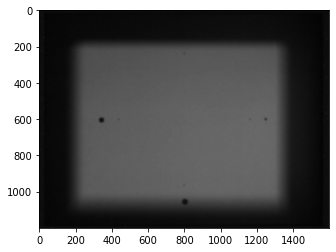

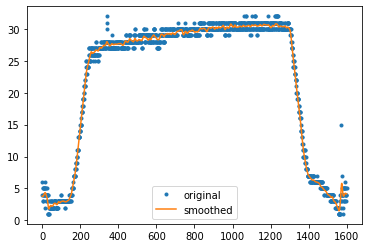

In [5]:
# Plot an intensity profile and a smoothed image for fun
plt.imshow(blur_img[0,...], cmap='gray', vmin=0, vmax=75)
plt.show()
plt.plot(img[0,800,:],'.', label='original')
plt.plot(blur_img[0,800,:], label='smoothed')
plt.legend()
plt.show()

Calculate the x and y gradients of pixel intensity ofr each blurred image.
Loop through each image, then each row and each column. For every pixel, measure the gradient simply by subtracting adjacent pixels separated by a distance dictated by the variable `kernel_size`.  
  
This is a slow process that could be sped up using a convolution-based approach. OpenCV has plenty of functions capable of doing this.  
  
The x and y gradients are saved to arrays `dx` and `dy` respectively. The gradient magnitude is calculated from `dx` and `dy` and saved to the variable `grad_img`.

In [6]:
# This is a simple (and slow) gradient detection
kernel_size = 20
dx = np.zeros(img.shape) # x-axis gradient
dy = np.zeros(img.shape) # y-axis gradient

# Assess each pixel by looping through each image, row and column 
for i in range(img.shape[0]):
    for row in range(kernel_size, img.shape[1]-kernel_size):
        for col in range(kernel_size, img.shape[2]-kernel_size):
            # calculate gradient at pixel
            dx[i,row,col] = blur_img[i,row,col+kernel_size] - blur_img[i,row,col-kernel_size]
            dy[i,row,col] = blur_img[i,row+kernel_size,col] - blur_img[i,row-kernel_size,col]

grad_img = np.sqrt(dx**2+dy**2) # calculate magnitude of gradients

Plot a gradient profile  and image for fun

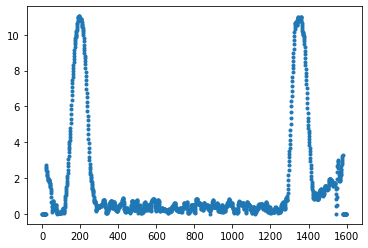

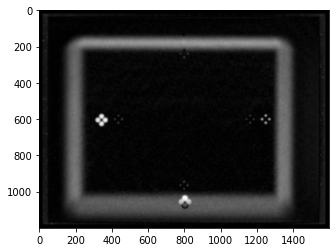

In [7]:
# Plot a gradient profile and a gradient image for fun
plt.plot(grad_img[1,800,:],'.')
plt.show()
plt.imshow(grad_img[1,...], cmap='gray')
plt.show()

The goal now is to locate the kV field edges from the gradient images. This can be done by finding the peaks in `grad_img` profiles.  
  
However, the gradient signal from markers placed on the Logos can confound the simple peak-finding algorithm we're going to use.  

Instead of wasting time thinking up clever ways to automatically detect and ignore the markers, let's manually "Null" rows & columns occupied by them.

In [8]:
# null BB rows & cols
dx[:,550:670,:] = 0#np.nan # horizontal null
dx[:,:,770:840] = 0#np.nan # vertical null
dy[:,550:670,:] = 0#np.nan # horizontal null
dy[:,:,770:840] = 0#np.nan # vertical null

Now normalise the field edges in each row of the x-axis gradient images.  

Loop through each `dx` image and identify the maximum absolute gradient. Write this value to `xmax`.  
  
Loop through every row in the `dx` image, assess whether a field edge is present by the value of the maximum pixel value relative to `xmax`.  If the row's maximum pixel value is > 80% of `xmax`, assume field edges are present and normalise them. If not, set the entire row's values to 0.

In [9]:
# show only absolute gradient
dx = np.abs(dx)

# threshold and normalise
for i in range(img.shape[0]):
    #find max gradient in image
    xmax = np.max(dx[i,...])

    # threshold rows & cols
    for j in range(img.shape[1]):
        a_max = np.max(dx[i,j,:770]) # find max value of left hand side peak (A-side)
        b_max = np.max(dx[i,j,839:]) # find max value of right hand side peak (B-side)
        
        # normalise A & B peaks if maximum A value is > 80% of max gradient
        if a_max < xmax*0.8:
            dx[i,j,:] = 0
        else:
            dx[i,j,:770] = dx[i,j,:770] / a_max
            dx[i,j,839:] = dx[i,j,839:] / b_max

Do the same for each column in the y-axis gradient images.

In [10]:
# show only absolute gradient
dy = np.abs(dy)

# threshold and normalise
for i in range(img.shape[0]):
    #find max gradient in image
    colmax = np.max(dy[i,:,:])
    
    for k in range(img.shape[2]):
        g_max = np.max(dy[i,:550,k]) # find max value of left hand side peak (G-side)
        t_max = np.max(dy[i,670:,k]) # find max value of right hand side peak (T-side)
        
        # normalise G & T peaks if maximum A value is > 80% of max gradient
        if g_max < colmax*0.8:
            dy[i,:,k]=0
        else:
            dy[i,:550,k] = dy[i,:550,k] / g_max
            dy[i,669:,k] = dy[i,669:,k] / t_max

Display some normalised images and profiles for fun

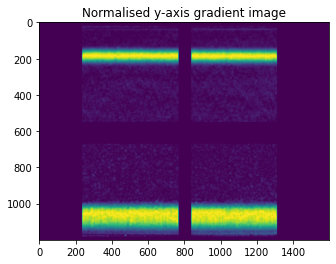

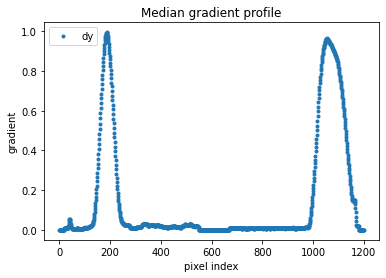

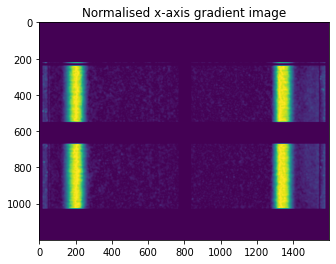

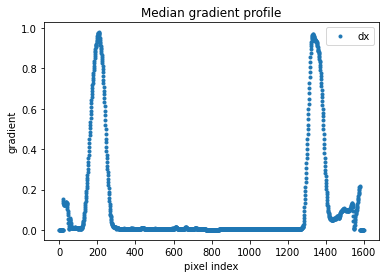

In [11]:
plt.imshow(dy[0,...])
plt.title('Normalised y-axis gradient image')
plt.show()
plt.plot(np.median(dy[0,:,:],1),'.', label='dy')
plt.legend()
plt.title('Median gradient profile')
plt.xlabel('pixel index')
plt.ylabel('gradient')
plt.show()
plt.imshow(dx[0,...])
plt.title('Normalised x-axis gradient image')
plt.show()
plt.plot(np.median(dx[0,:,:],0),'.', label='dx')
plt.legend()
plt.title('Median gradient profile')
plt.xlabel('pixel index')
plt.ylabel('gradient')
plt.show()

Find A and B field edge coordinates and save them to respective dictionaries `edge_a` and `edge_b`.  
  
Field edges are defined by the 50% point of a gradient peak's outer edge.  

To find edge coordinates: loop through each `dx` image. Find the A edge in each row and write their x and y coordinates to respective lists (e.g. `xa` and `ya`).

In [130]:
# AB edge results dicts
edge_a = {}
edge_b = {}

for i in range(img.shape[0]):
    # edge coordinate lists
    xa = []
    ya = []
    xb = []
    yb = []

    for j in range(img.shape[1]): # loop through image rows
        row = np.squeeze(dx[i,j,:])

        # analyse row if it contains a peak
        if np.nanmax(row)==1:
            # find A & B peak locations
            a_max = np.argmax(row[0:400])
            b_max = np.argmax(row[1000:1599])+1000

            # starting at the peak, move away from the image centre and find the 50% peak height coordinate (where halfdiff ~ 0)
            halfdiff = row-0.9
            for k in range(a_max,1,-1): # A peak
                if halfdiff[k-1]<0 and halfdiff[k+1]>0:
                    xa.append(k)
                    ya.append(j)
                    break
            for k in range(1599,b_max,-1): # B peak
                if halfdiff[k-1]>0 and halfdiff[k+1]<0:
                    xb.append(k)
                    yb.append(j)
                    break
    
    #write x and y coordinates to a single list in the edge dict
    edge_a[str(i)]=[xa,ya]
    edge_b[str(i)]=[xb,yb]


Plot the A and B edge coordinates from an image. For FUN.

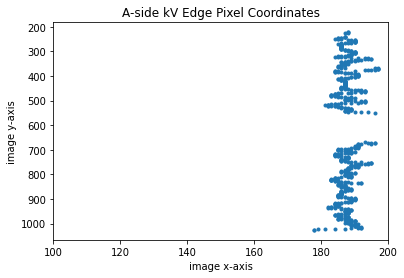

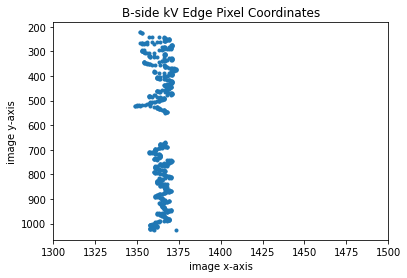

In [131]:
# A edge coordinate
plt.plot(edge_a['0'][0],edge_a['0'][1],'.')
plt.xlim([100,200])
plt.xlabel('image x-axis')
plt.ylabel('image y-axis')
plt.title('A-side kV Edge Pixel Coordinates')
plt.gca().invert_yaxis() # y axis reversed to give same orientation as image display
plt.show()

plt.plot(edge_b['0'][0],edge_b['0'][1],'.')
plt.xlim([1300,1500])
plt.xlabel('image x-axis')
plt.ylabel('image y-axis')
plt.title('B-side kV Edge Pixel Coordinates')
plt.gca().invert_yaxis() # y axis reversed to give same orientation as image display
plt.show()

Calculate GT field edge coordinates in similar fashion to AB edges.

In [132]:
# GT edge results dicts
edge_g = {}
edge_t = {}

for i in range(img.shape[0]):
    # edge coordinate lists
    xg = []
    yg = []
    xt = []
    yt = []

    for k in range(img.shape[2]): # loop through image columns
        col = np.squeeze(dy[i,:,k])

        # analyse column if it contains a peak
        if np.nanmax(col)==1:
            # find G & T peak locations
            g_max = np.argmax(col[0:400])
            t_max = np.argmax(col[800:1200])+800

            # starting at the peak, move away from the image centre and find the 50% peak height coordinate (where halfdiff ~ 0)
            halfdiff = col-0.9
            for j in range(g_max,1,-1): # G edge
                if halfdiff[j-1]<0 and halfdiff[j+1]>0:
                    xg.append(k)
                    yg.append(j)
                    break
            for j in range(1200,t_max,-1): # T edge
                if halfdiff[j-1]>0 and halfdiff[j+1]<0:
                    xt.append(k)
                    yt.append(j)
                    break

    #write x and y coordinates to a single list in the edge dict
    edge_g[str(i)]=[xg,yg]
    edge_t[str(i)]=[xt,yt]

Plot all field edge coordinates in an image for maximum fun.

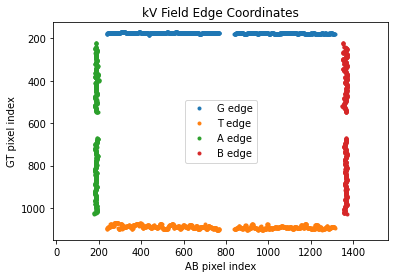

In [133]:
plt.plot(edge_g['0'][0],edge_g['0'][1],'.',label='G edge')
plt.plot(edge_t['0'][0],edge_t['0'][1],'.',label='T edge')
plt.plot(edge_a['0'][0],edge_a['0'][1],'.',label='A edge')
plt.plot(edge_b['0'][0],edge_b['0'][1],'.',label='B edge')
plt.axis('equal')
plt.gca().invert_yaxis()
plt.legend()
plt.title('kV Field Edge Coordinates')
plt.xlabel('AB pixel index')
plt.ylabel('GT pixel index')
plt.show()

Next Steps:  
* Find the small BBs in the kV images and use them to calculate laser centre coordinates in each image
* Calculate pixel size from BB coordinates (small BBs are 10cm from laser iso)
* Calculate the laser centre position in mm
* Using info in DataAnalysis.xlsx:
    * Calculate mean field edge coordinates from laser isocentre
    * Using the couch height for each image, apply a linear fit to distance from iso vs. couch height
    * Extrapolate the fit to panel distance from iso
    * Calculate field dimensions at the panel

Detect small BBs and derive pixel size

AB pixel size = 0.2751031636863824
GT pixel size = 0.27586206896551724
A BB index = 438
B BB index = 1165
G BB index = 239
T BB index = 964
Laser coordinates in pixels (x,y) = [801.5 601.5]
Laser coordinates in mm (x,y) = [220.79931699 165.70279372]


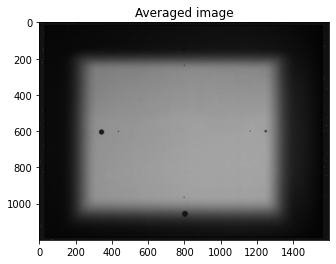

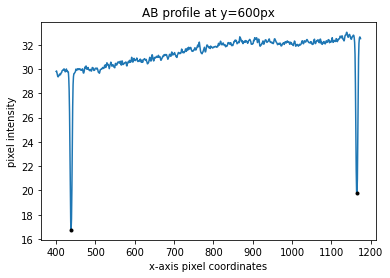

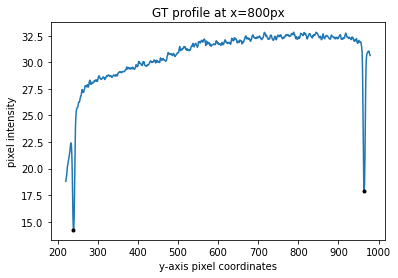

In [134]:
# average all images together and then extract profiles across small BBs 
avg_img = np.mean(img,0)
h_profile = np.mean(avg_img[601-4:601+4,:],0)
v_profile = np.mean(avg_img[:,801-4:801+4],1)

# find minima indices
a_idx = np.argmin(h_profile[400:500])+400
b_idx = np.argmin(h_profile[1100:1200])+1100
g_idx = np.argmin(v_profile[220:300])+220
t_idx = np.argmin(v_profile[900:1000])+900

# calculate pixel size in mm
px_x = 200/(b_idx-a_idx)
px_y = 200/(t_idx-g_idx)
px2mm = (px_x+px_y)/2

# calculate laser centre
laser_isopx = np.array((a_idx+(b_idx-a_idx)/2, g_idx+(t_idx-g_idx)/2))
laser_isomm = laser_isopx * ((px_x+px_y)/2)

# plot for fun
print("AB pixel size = " + str(200/(b_idx-a_idx)) + 
        "\nGT pixel size = " + str(200/(t_idx-g_idx)) +
        "\nA BB index = " + str(a_idx) +
        "\nB BB index = " + str(b_idx) +
        "\nG BB index = " + str(g_idx) +
        "\nT BB index = " + str(t_idx) +
        "\nLaser coordinates in pixels (x,y) = " + str(laser_isopx) +
        "\nLaser coordinates in mm (x,y) = " + str(laser_isomm)
        )
plt.imshow(avg_img, cmap='gray', vmin=0, vmax=avg_img.max()-200)
plt.title("Averaged image")
plt.show()
plt.plot(range(400,1175),h_profile[400:1175])
plt.plot([a_idx,b_idx],[h_profile[a_idx], h_profile[b_idx]],'k.')
plt.title("AB profile at y=600px")
plt.xlabel("x-axis pixel coordinates")
plt.ylabel("pixel intensity")
plt.show()
plt.plot(range(220,980),v_profile[220:980])
plt.plot([g_idx,t_idx],[v_profile[g_idx], v_profile[t_idx]],'k.')
plt.title("GT profile at x=800px")
plt.xlabel("y-axis pixel coordinates")
plt.ylabel("pixel intensity")
plt.show()




Calculate mean edge coordinates in mm relative to laser iso for each image

In [135]:
a_mm = []
b_mm = []
g_mm = []
t_mm = []
ab_cnt = []
gt_cnt = []
# loop through images
for i in range(img.shape[0]):
    a_mm.append((np.mean(edge_a[str(i)][0])-laser_isopx[0])*px2mm)
    b_mm.append((np.mean(edge_b[str(i)][0])-laser_isopx[0])*px2mm)
    g_mm.append((np.mean(edge_g[str(i)][1])-laser_isopx[1])*px2mm)
    t_mm.append((np.mean(edge_t[str(i)][1])-laser_isopx[1])*px2mm)
    ab_cnt.append(((np.mean(edge_a[str(i)][0])-laser_isopx[0])*px2mm + (np.mean(edge_b[str(i)][0])-laser_isopx[0])*px2mm) / 2)
    gt_cnt.append(((np.mean(edge_g[str(i)][1])-laser_isopx[1])*px2mm + (np.mean(edge_t[str(i)][1])-laser_isopx[1])*px2mm) / 2)


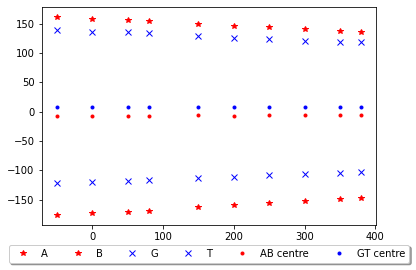

In [142]:
couch_heights = [   80,
                    50,
                    0,
                    -50,
                    150,
                    200,
                    250,
                    300,
                    350,
                    380,
                    ]
plt.plot(couch_heights,a_mm,'r*', label='A')
plt.plot(couch_heights,b_mm,'r*', label='B')
plt.plot(couch_heights,g_mm,'bx', label='G')
plt.plot(couch_heights,t_mm,'bx', label='T')
plt.plot(couch_heights,ab_cnt,'r.', label='AB centre')
plt.plot(couch_heights,gt_cnt,'b.', label='GT centre')
plt.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.07),
           fancybox=True, shadow=True, ncol=6)
plt.show()

Linear fit to field edges

In [143]:
# calculate linear fits
Afit = np.polyfit(couch_heights, a_mm, 1)
Bfit = np.polyfit(couch_heights, b_mm, 1)
Gfit = np.polyfit(couch_heights, g_mm, 1)
Tfit = np.polyfit(couch_heights, t_mm, 1)
ABfit = np.polyfit(couch_heights, ab_cnt, 1)
GTfit = np.polyfit(couch_heights, gt_cnt, 1)

# Estimate field edges at panel
panel = -1000
Apanel = Afit[0]*panel + Afit[1]
Bpanel = Bfit[0]*panel + Bfit[1]
Gpanel = Gfit[0]*panel + Gfit[1]
Tpanel = Tfit[0]*panel + Tfit[1]
ABpanel = ABfit[0]*panel + ABfit[1]
GTpanel = GTfit[0]*panel + GTfit[1]

# Estimate field edges at source
source = 2700
Asource = Afit[0]*source + Afit[1]
Bsource = Bfit[0]*source + Bfit[1]
Gsource = Gfit[0]*source + Gfit[1]
Tsource = Tfit[0]*source + Tfit[1]
ABsource = ABfit[0]*source + ABfit[1]
GTsource = GTfit[0]*source + GTfit[1]

print("Linear fits:")
print(Afit)
print(Bfit)
print(Gfit)
print(Tfit)
print(ABfit)
print(GTfit)

Linear fits:
[ 6.66030173e-02 -1.73114615e+02]
[-6.18555849e-02  1.59302595e+02]
[ 4.68392295e-02 -1.20406301e+02]
[-5.03417012e-02  1.37138599e+02]
[ 2.37371617e-03 -6.90600998e+00]
[-1.75123585e-03  8.36614900e+00]


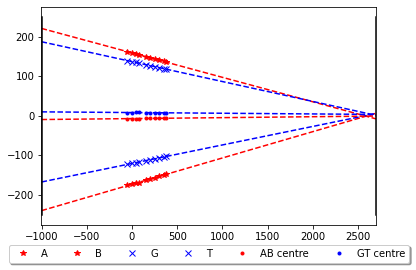

In [144]:
#plot linear fits
plt.plot(couch_heights,a_mm,'r*', label='A')
plt.plot(couch_heights,b_mm,'r*', label='B')
plt.plot(couch_heights,g_mm,'bx', label='G')
plt.plot(couch_heights,t_mm,'bx', label='T')
plt.plot(couch_heights,ab_cnt,'r.', label='AB centre')
plt.plot(couch_heights,gt_cnt,'b.', label='GT centre')
plt.plot([panel, source],[Apanel,Asource],'r--')
plt.plot([panel, source],[Bpanel,Bsource],'r--')
plt.plot([panel, source],[Gpanel,Gsource],'b--')
plt.plot([panel, source],[Tpanel,Tsource],'b--')
plt.plot([panel, source],[ABpanel,ABsource],'r--')
plt.plot([panel, source],[GTpanel,GTsource],'b--')
plt.plot([-1000,-1000],[-250,250],'k-')
plt.plot([2700,2700],[-250,250],'k-')
plt.xlim([-1001,2701])
plt.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.07),
           fancybox=True, shadow=True, ncol=6)
plt.show()

In [145]:
print("A edge from laser centre at panel: "+str(Apanel) + " mm")
print("B edge from laser centre at panel: "+str(Bpanel) + " mm")
print("G edge from laser centre at panel: "+str(Gpanel) + " mm")
print("T edge from laser centre at panel: "+str(Tpanel) + " mm")
print("AB centre from laser centre at panel: "+str(ABpanel) + " mm")
print("GT centre from laser centre at panel: "+str(GTpanel) + " mm")

A edge from laser centre at panel: -239.7176318699701 mm
B edge from laser centre at panel: 221.1581795636547 mm
G edge from laser centre at panel: -167.24553066238292 mm
T edge from laser centre at panel: 187.48030037777272 mm
AB centre from laser centre at panel: -9.279726153157684 mm
GT centre from laser centre at panel: 10.117384857694942 mm
